In [1]:
import sys
import os

import pandas as pd


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pathlib import Path
import yaml
from src.minimizer.minimizer_library.differential_evolution_parallel import DifferentialEvolutionParallel
from src.statistical_models.statistical_model_library.fcs_gaussian_noise_model import FCSGaussianNoiseModel
from src.visualization.plotting_functions import *
from src.math_utils.experiment_metrics import calculate_estimator_metrics
from src.math_utils.derivatives.numeric_derivative_calculator import NumericDerivativeCalculator
from src.model.hahn_stack_model import HahnStackModel
from src.math_utils.scaler.hahn_parameter_scaler import HahnParameterScaler
from src.model.parameter_set.hahn_parameter_set import HahnParameterSet
from src.utils.experiment_serialization import combine_experiments

In [2]:
path = "../data/config/oed_config_demo.yaml"

with open(path, "r") as f:
    config = yaml.safe_load(f)

number_designs = config["number_designs"]  #Amount of LH Designs
n_rep = config["n_rep"]  #Amount of experiment repetitions
n_current_values = config["n_current_values"]  #Amount of individual current values
sigma = config["sigma"]  #experiment variance (10mV variance in repeated experiments)
number_new_designs = config["number_new_designs"]
iterations = config["iterations"]
index = config["parameter_index"]

# lower and upper bounds for operating conditions
upper_bounds_operating_conditions = np.array(config["upper_bounds_operating_conditions"])
lower_bounds_operating_conditions = np.array(config["lower_bounds_operating_conditions"])

I_S_array = np.linspace(1, 480, n_current_values)  # initialize applicable current array request

# initialize applicable parameter set
unscaled_theta_true = np.array(list(HahnParameterSet().free_parameters.values())[:6])
names_theta = list(HahnParameterSet().free_parameters.keys())[:6]

# initialize lower and upper bounds for free parameter values
unscaled_upper_bounds_free_params = np.array(config["unscaled_upper_bounds_free_params"])
unscaled_lower_bounds_free_params = np.array(config["unscaled_lower_bounds_free_params"])

print(names_theta, unscaled_lower_bounds_free_params, unscaled_theta_true, unscaled_upper_bounds_free_params)

['E_A', 'j_0_ref', 'r_el', 'D_CL_ref', 'D_GDL_ref', 'f_CL'] ['1000' '100' '1e-7' '1e-9' '1e-7' '0.01'] [7.1477e+04 2.1308e+03 4.2738e-06 3.3438e-08 8.6266e-06 3.6693e-01] ['100000' '10000' '1e-5' '1e-7' '1e-5' '1']


In [3]:
scaler = HahnParameterScaler()

X_train = np.vstack([
    unscaled_lower_bounds_free_params,
    unscaled_upper_bounds_free_params
]).T

# Stack operating condition bounds (rows = condition, columns = [min, max])
operating_condition_bounds = np.vstack([
    lower_bounds_operating_conditions,
    upper_bounds_operating_conditions
]).T

# Determine current range for scaling
current_bounds = np.array([[I_S_array.min(), I_S_array.max()]])

stacked_params = np.vstack((operating_condition_bounds, current_bounds))
scaled_theta_true = scaler.scale_theta(unscaled_theta_true, X_train)

scaled_upper_bounds = scaler.scale_params(upper_bounds_operating_conditions, operating_condition_bounds)
scaled_lower_bounds = scaler.scale_params(lower_bounds_operating_conditions, operating_condition_bounds)

scaled_lower_bounds_theta, _ = scaler.scale(unscaled_lower_bounds_free_params, X_train)
scaled_upper_bounds_theta, _ = scaler.scale(unscaled_upper_bounds_free_params, X_train)

# Print results
print("Scaled theta:", scaled_theta_true)
print("Rescaled theta:", unscaled_theta_true)

Scaled theta: [0.71188889 0.20513131 0.42159596 0.32765657 0.86127273 0.36053535]
Rescaled theta: [7.1477e+04 2.1308e+03 4.2738e-06 3.3438e-08 8.6266e-06 3.6693e-01]


In [4]:
hahn_fc_model = HahnStackModel(parameter_set=HahnParameterSet())
calculator = NumericDerivativeCalculator(hahn_fc_model, scaler)

statistical_model = FCSGaussianNoiseModel(model_function=hahn_fc_model,
                                          der_function=calculator,
                                          lower_bounds_x=scaled_lower_bounds,
                                          upper_bounds_x=scaled_upper_bounds,
                                          lower_bounds_theta=scaled_lower_bounds_theta,
                                          upper_bounds_theta=scaled_upper_bounds_theta,
                                          sigma=sigma,
                                          scaler = scaler,)

def blackbox_model(x):
    return statistical_model.random(theta=scaled_theta_true, x=x)

In [5]:
import_path = ".." / Path("data") / "experimental_designs"
# Read lhc from file system
lhc_data = pd.read_csv(import_path/"lhc"/"lhc_demo.csv")
LH = lhc_data.values[:,:-1]

# Read oed from file system
oed_data = pd.read_csv(import_path/"pi"/"pi_design_demo.csv")
oed = oed_data.values[:,:-1]

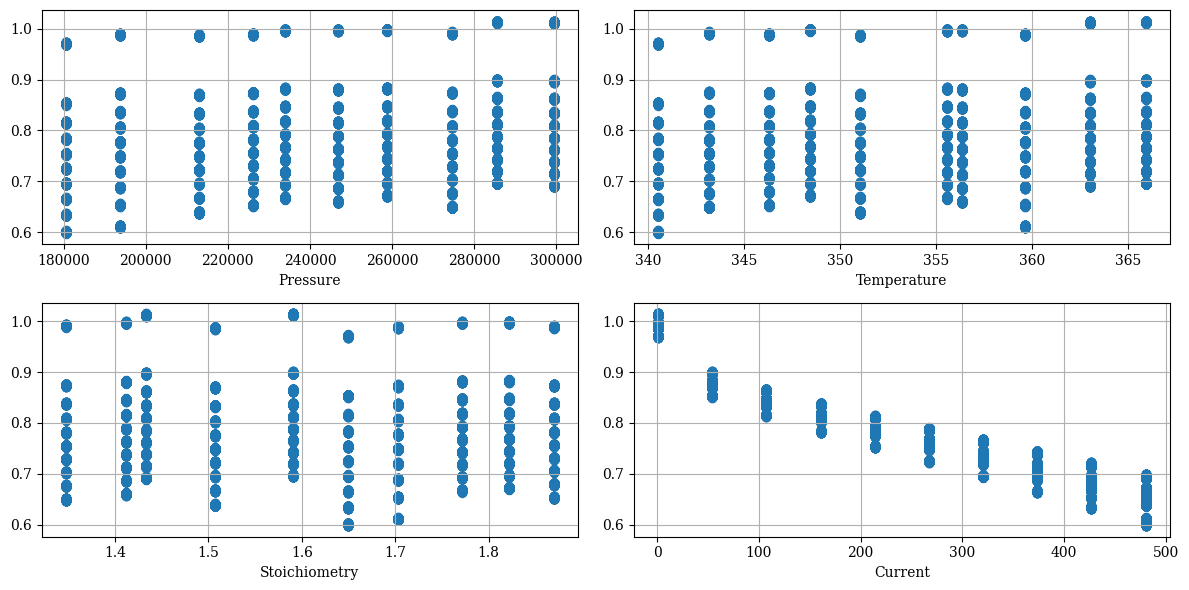

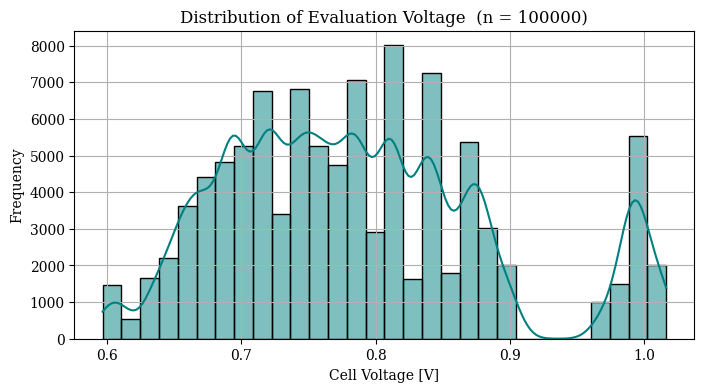

In [6]:
evaluation_LH_experiment = lhc_data.values[:,-1]
x_LH_design = LH

plot_blackbox_evaluation(x_LH_design, evaluation_LH_experiment,
                         input_labels=["Pressure", "Temperature", "Stoichiometry", "Current"])

In [7]:
from src.math_utils.experiment_metrics import calculate_experiment_metrics

# _, x0_LH_design = evaluate_blackbox_region(blackbox_model, LH.experiment, I_S_array)

x0_LH_design = x_LH_design[:n_current_values*number_designs,:]

(FIM_LH_experiment,
 det_FIM_LH_experiment,
 diagonal_CRLB_LH_experiment,
 CLRB_LH_experiment,
 std_LH_Experiment) = calculate_experiment_metrics(statistical_model, scaled_theta_true, x0_LH_design)

print(f"total amount of LH designs with current and repetitions: {len(x_LH_design)}")
print(f"total amount of LH designs with current: {len(x0_LH_design)}")
print(f"FIM LH experiment:\n {FIM_LH_experiment}")
print(f"determinant of FIM:\n {det_FIM_LH_experiment}")
print("CRLB of Latin Hypercube experiment at initial theta: \n",
      diagonal_CRLB_LH_experiment)
print('The relative expected standard deviations of the LH estimators are \n',
      std_LH_Experiment)

total amount of LH designs with current and repetitions: 100000
total amount of LH designs with current: 100
FIM LH experiment:
 [[   39302.3321087     -9901.79040548     8243.28634749   -20519.30420618
     -1721.23934602    -5647.89692675]
 [   -9901.79040548  1420040.55803384 -1182195.91079164   633741.53504574
    153383.58894532   295750.20912423]
 [    8243.28634749 -1182195.91079164  1381825.98697917  -786736.11377382
   -201686.54494849  -351714.26821321]
 [  -20519.30420618   633741.53504574  -786736.11377382   497359.71337111
    129517.53408025   207845.70028202]
 [   -1721.23934602   153383.58894532  -201686.54494849   129517.53408025
     35484.95542567    53343.99446937]
 [   -5647.89692675   295750.20912423  -351714.26821321   207845.70028202
     53343.99446937    90865.09851736]]
determinant of FIM:
 1.2072397152442637e+26
CRLB of Latin Hypercube experiment at initial theta: 
 [4.54967142e-05 2.91093030e-06 2.36273074e-04 3.61488183e-04
 9.94393004e-04 7.78671716e-03]


## Pi-Design

In [8]:
x0_oed_design = oed[:n_current_values*number_new_designs,:]
evaluation_oed_experiment = oed_data.values[:,-1]

LH_oed_design = np.vstack((x0_LH_design, x0_oed_design))

(FIM_LH_oed_experiment,
 det_FIM_LH_oed_experiment,
 diagonal_CRLB_LH_oed_experiment,
 CRLB_LH_oed_experiment,
 std_LH_oed_Experiment) = calculate_experiment_metrics(statistical_model, scaled_theta_true, LH_oed_design)

# print(f"additional experimental designs from the Pi calculation:\n {pi_design}")
print(
    f"amount of additional experimental designs with current values: {len(evaluation_oed_experiment)}")  # should be number of Pi-Designs times number of current values
print(
    f"total amount of experimental designs from LH + Pi: {len(LH_oed_design)}")  # should be number of (Pi-Designs + number of LH designs) * current values
print(f"FIM LH + Pi designs:\n {FIM_LH_oed_experiment}")
print(
    f"The determinant of the Fisher information matrix at the theta true and LH + Pi designs is \n{det_FIM_LH_oed_experiment}")
print("CRLB of Latin Hypercube Pi designs at theta true: \n", diagonal_CRLB_LH_oed_experiment)
print('The relative expected standard deviations of the Pi-optimal parameter estimators are \n',
      std_LH_oed_Experiment)

amount of additional experimental designs with current values: 20000
total amount of experimental designs from LH + Pi: 120
FIM LH + Pi designs:
 [[   64104.30095015    74026.39665355   -61627.64681996    86762.596565
     56652.98028963    23335.80513672]
 [   74026.39665355  1704048.67159184 -1418635.09353277   996700.48844353
    350817.6991047    393832.36434285]
 [  -61627.64681996 -1418635.09353277  1658191.184375   -1274354.2996601
   -492395.97635292  -479211.56520286]
 [   86762.596565     996700.48844353 -1274354.2996601   1506368.71949834
    812784.80092028   456060.12115875]
 [   56652.98028963   350817.6991047   -492395.97635292   812784.80092028
    546591.64914422   211725.59680805]
 [   23335.80513672   393832.36434285  -479211.56520286   456060.12115875
    211725.59680805   154798.79242592]]
The determinant of the Fisher information matrix at the theta true and LH + Pi designs is 
1.4622053994028424e+30
CRLB of Latin Hypercube Pi designs at theta true: 
 [1.77920714e

In [9]:
n_workers=24
minimizer = DifferentialEvolutionParallel(maxiter=iterations, display=False, tol=1e-10, n_workers=n_workers)

LH_oed_experiment = combine_experiments(lhc_data.values, oed_data.values, n_rep)[:,:-1]

evaluation_LH_oed_experiment = combine_experiments(lhc_data.values, oed_data.values, n_rep)[:,-1]

oed_estimated_thetas = statistical_model.estimate_repeated_thetas(
    x0=LH_oed_experiment, y=evaluation_LH_oed_experiment, n=n_rep, minimizer=minimizer)

Estimating thetas: 100%|██████████| 1000/1000 [24:28:52<00:00, 88.13s/it]  


In [10]:
oed_estimated_theta_mean, oed_var_theta, oed_rel_error, oed_rel_std,_ = calculate_estimator_metrics(oed_estimated_thetas,scaled_theta_true,
                                                                                              diagonal_CRLB_LH_oed_experiment)

print("Resulting parameter estimate based on LH designs + Pi-Designs:  \n",
      oed_estimated_theta_mean)
# print(len(pi_design.experiment))
# print(len(x_LH_design))
# print(len(x_pi_experiment))
# print(len(LH_d_experiment))
# print(d_var_theta)

Resulting parameter estimate based on LH designs + Pi-Designs:  
 [0.71190742 0.20508405 0.42157061 0.32732353 0.86151253 0.36313031]


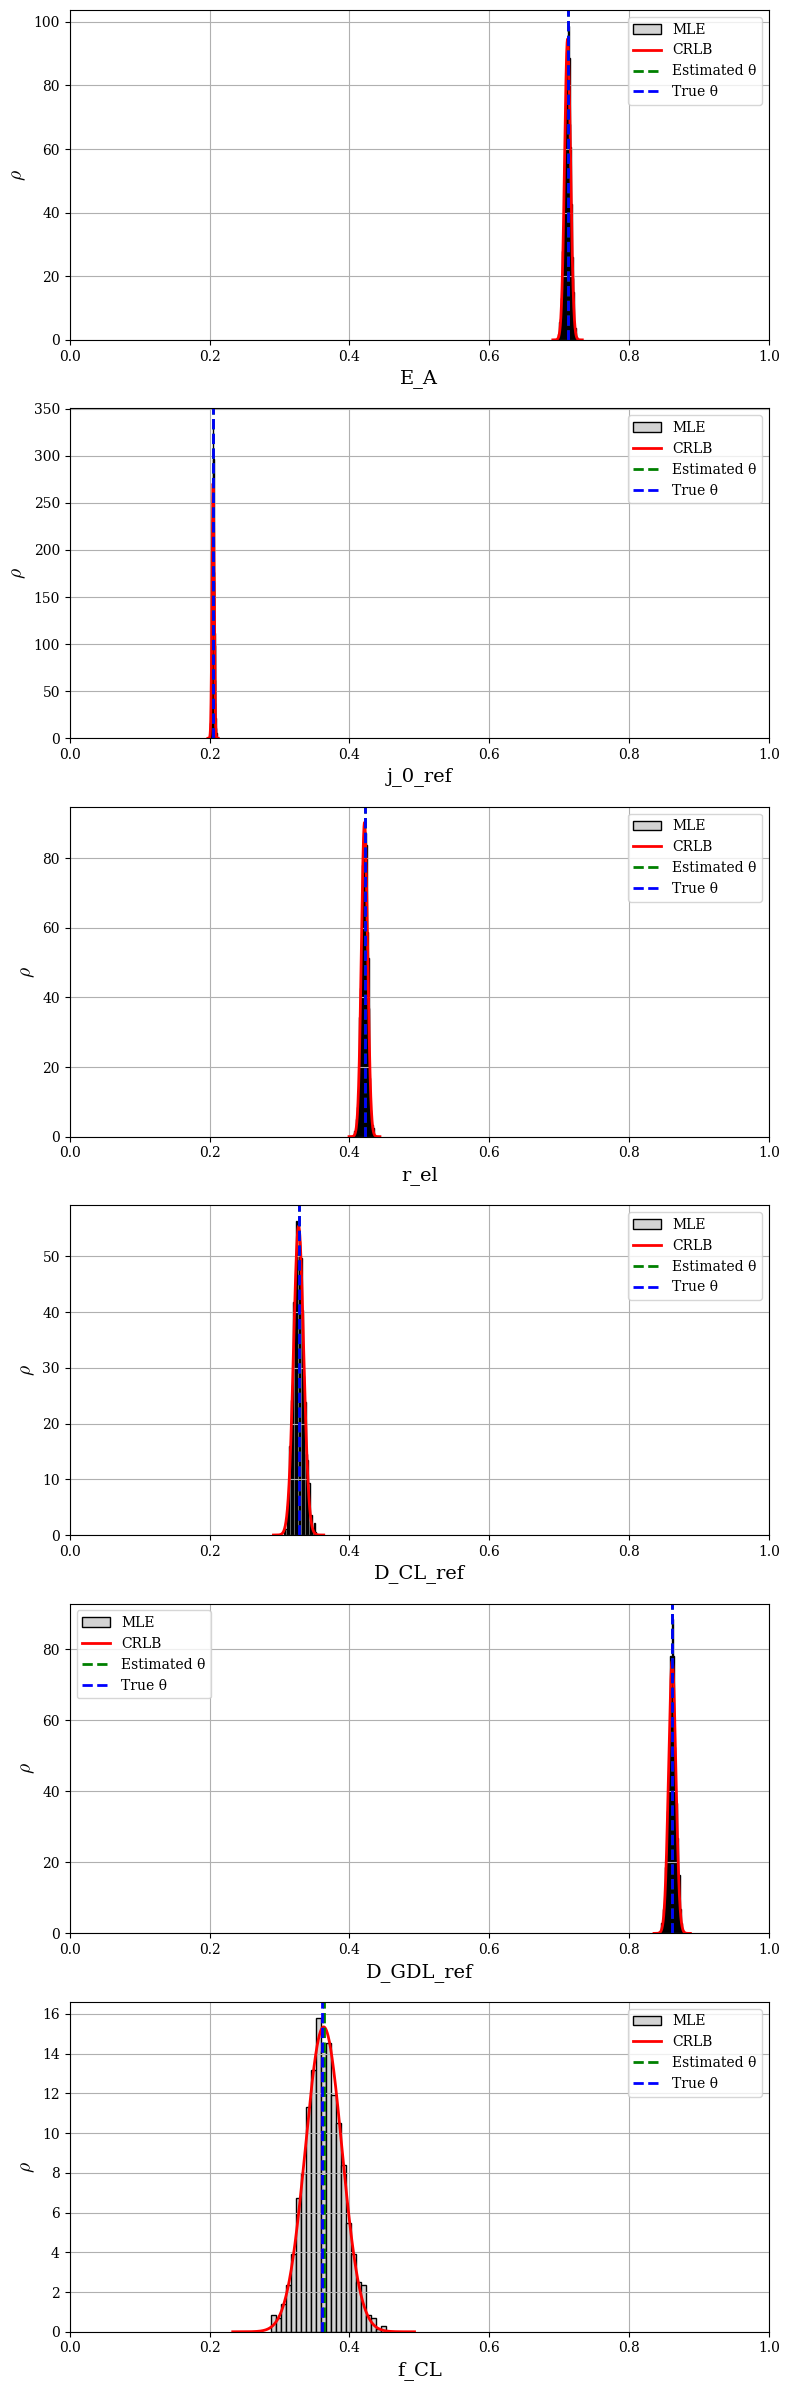

In [11]:
parameter_names = names_theta

plot_mle_vs_crlb(
    oed_estimated_thetas,  # <== this should be the MLE estimates!
    diagonal_CRLB_LH_oed_experiment,  # <== this should be the CRLB variances!
    scaled_theta_true,
    scaled_lower_bounds_theta,
    scaled_upper_bounds_theta,
    param_names=parameter_names,
)

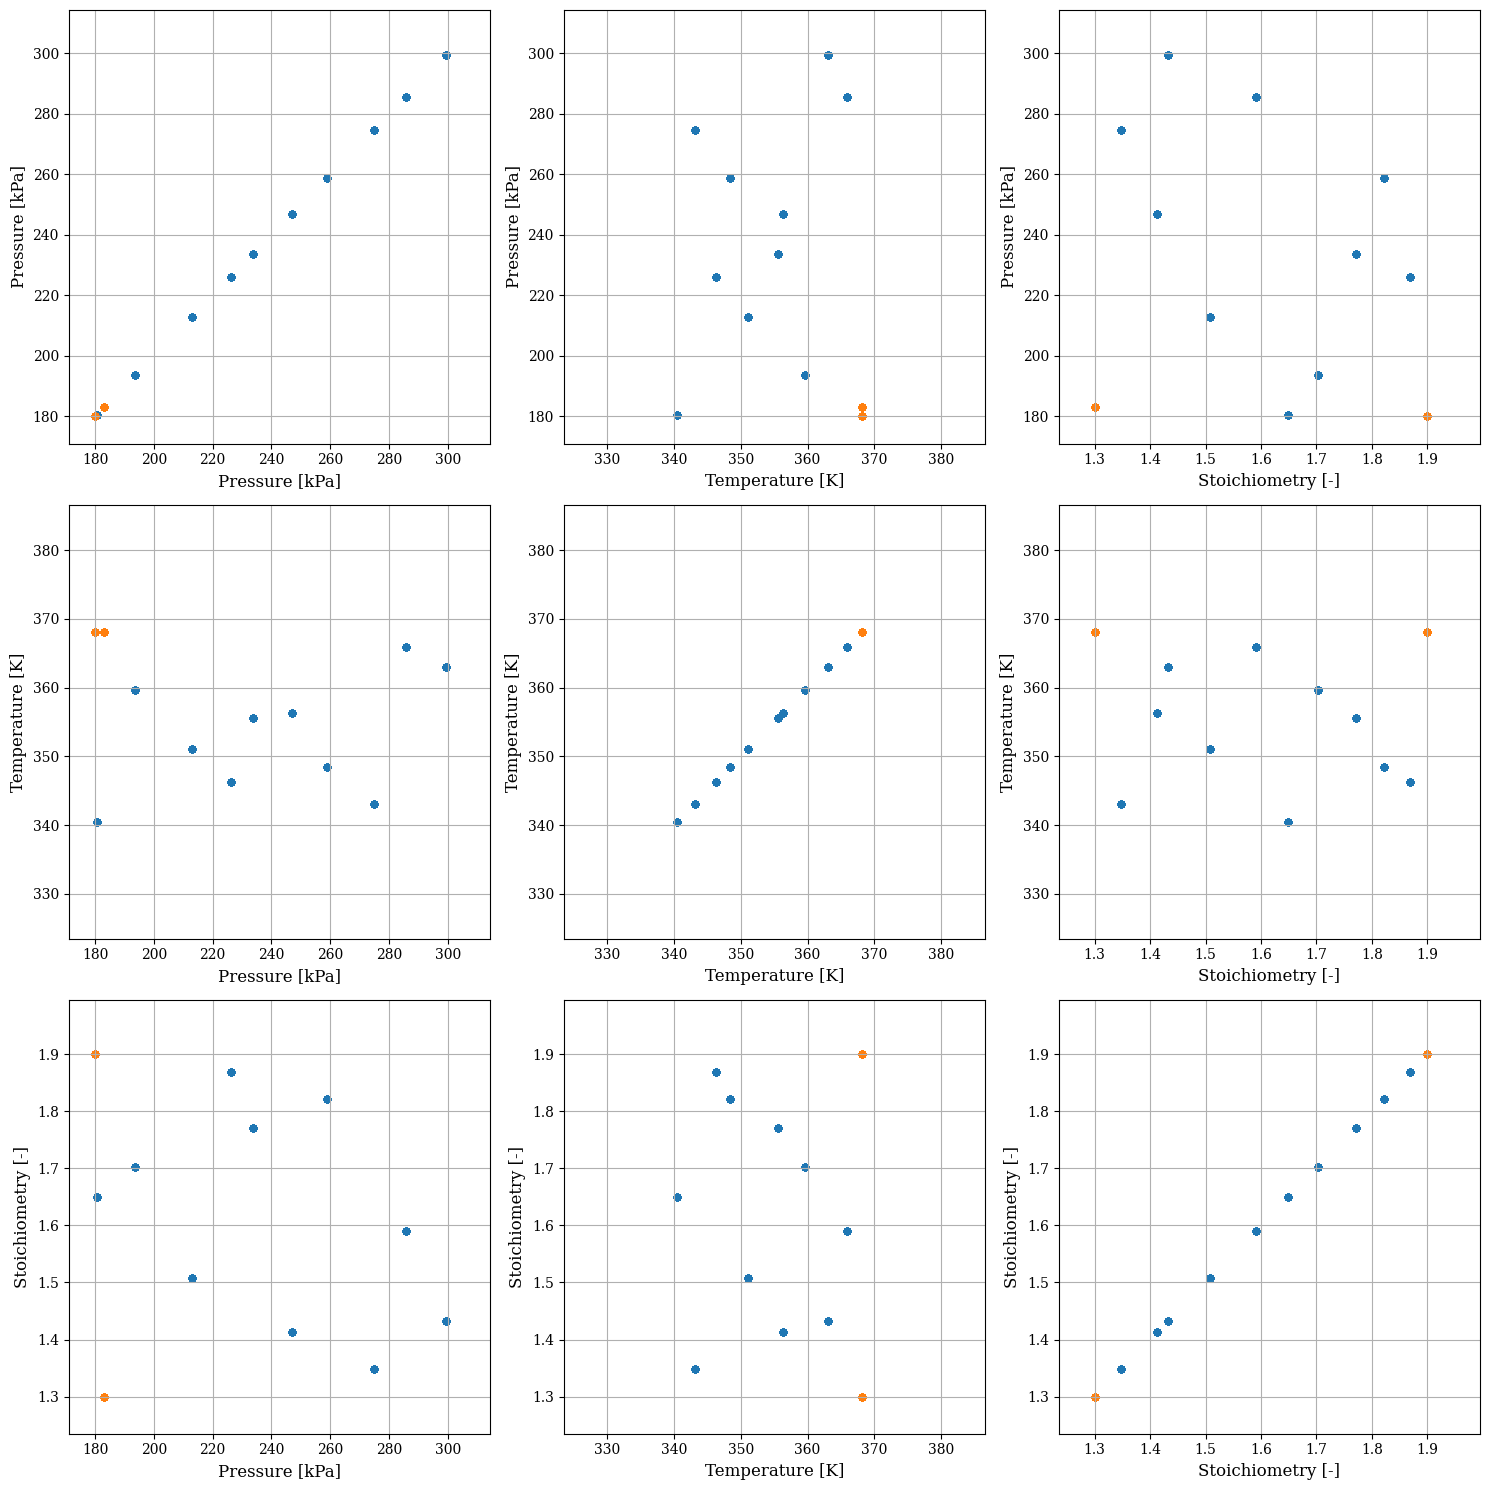

In [12]:
opCons = ["Pressure [kPa]", "Temperature [K]", "Stoichiometry [-]"]
plot_experiment_matrix([LH[:,:3], oed[:,:3]], opCons)

### Save Thetas as CSV

In [13]:
# save estimated thetas
root = Path.cwd().parent
data_path = root / "data" / "estimated_parameters" / "pi"

out_file = data_path / "estimated_thetas_demo.csv"

df_theta = pd.DataFrame(oed_estimated_thetas, columns=names_theta)
df_theta.to_csv(out_file, index=False)